In [194]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import os
import sys
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
proj_home_path="C:/vrsk.psk.family/Selva/BitsPilani/azure/semester4/semester4/SuperPoint"
sys.path.append(proj_home_path)

from superpoint.settings import EXPER_PATH
from superpoint.models.utils import box_nms 
from utils import plot_imgs
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# NON MAX SUPPRESSION 

In [195]:
def non_max_suppression_fast(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    boxes = boxes.astype("float")
    # initialize the list of picked indexes	
    pick = []
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick].astype("int")

# Magic Point Reading

In [245]:
def _read_magic_points(filename):
    mp = np.load(filename.decode('utf-8'))
    prob = mp['prob']
    prob_nms = mp['prob_nms']
    
    if 'prob_nms' in mp.keys():
        prob = mp['prob_nms'] 
    else:
        prob = mp['prob'] 
        
    pred = np.round(mp['pred'])
  
    idx = np.where(pred == 1)
    prob = prob[idx]
#     print('idx, prob: ', idx, prob)
    
#     idx = np.array(idx).T 
    
    f_output = [ idx.astype(np.int32), prob.astype(np.float32)]
    return f_output

def magicpoint(img_name_with_path):
    filename = img_name_with_path
    point = tf.py_func(_read_magic_points, [filename], [tf.int32, tf.float32])
#     print('points.shape, prob.shape: ', point[0], point[1])
    f_output = {'points': point[0], 'prob': point[1]} 
    return f_output

# Harris point Reading

In [269]:
def harris_gen(im):
    filename1 = im.decode('utf-8')
    img = cv2.imread(filename1)
    img = np.uint8(img * 255)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    gray = gray.astype(np.float32)
    dst = cv2.cornerHarris(gray,2,3,0.04)
    dst = cv2.dilate(dst,None)

    keep_top_k = 300
    size = 4 
    size = size/2.
    overlap_threshold = 0.01

    ######### Location & Prob from Harris ##################
    pts = np.where(dst > 0.01 * dst.max())
    scores = dst[pts]
    
    ########## Frame box & Suppress using NMS ###############
    pts = np.array(pts).T
    box = np.concatenate([pts-size, pts+size], axis=1)
    indices = non_max_suppression_fast(box, overlap_threshold)
    indices = indices[:,:2]+size
    indices = np.round(indices).astype(np.int32)
    indices_t = np.array(indices).T
    
    ########## Location & Prob after NMS ####################
    nms_pts = tuple(indices_t[0]),tuple(indices_t[1])
    nms_scores = dst[nms_pts]
    f_output = [indices.astype(np.int32), nms_scores.astype(np.float32)] 
    return f_output

def harris_detector(filename):
    threshold = 0.001
    nms = 4.
    top_k = 300
    point = tf.py_func(harris_gen, [filename], [tf.int32,tf.float32])
    f_output = {'points': point[0], 'prob': point[1]} 
    return f_output

# SIFT Reading

In [343]:
def sift_gen(filename):
    filename1 = filename.decode('utf-8')
    img = cv2.imread(filename1)
    img = np.uint8(img * 255)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#     gray = img.astype(np.float32)
    print('sift_gen: ', gray.shape)
    
    sift = cv2.xfeatures2d.SIFT_create(nfeatures=1500)
    keypoints, desc = sift.detectAndCompute(gray, None)
    responses = np.array([k.response for k in keypoints])
    keypoints = np.array([k.pt for k in keypoints]).astype(int)
    desc = np.array(desc)

    detections = np.zeros(img.shape[:2], np.float)
    print('keypoints.shape, detections.shape, response.shape: ', keypoints.shape, detections.shape, responses.shape)
    detections[keypoints[:, 1], keypoints[:, 0]] = responses
    descriptors = np.zeros((img.shape[0], img.shape[1], 128), np.float)
    descriptors[keypoints[:, 1], keypoints[:, 0]] = desc    
    
    return [keypoints.astype(np.int32), detections.astype(np.float32), descriptors.astype(np.float32)]
    
def sift_detector(filename):
    point = tf.py_func(sift_gen, [filename], [tf.int32, tf.float32, tf.float32])
    f_output = {'points': point[0], 'prob': point[1], "desc" : point[2]} 
    return f_output

# Superpoint Reading

In [344]:
def _path(filename):
    val = Path(filename.decode('utf-8'))
    return str(val)

def _name(filename):
    val = Path(filename.decode('utf-8')).stem
    return val

def _read_image(filename):
    image = tf.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=1)
#     print('_read_image complete.....')
    return tf.cast(image, tf.float32)

# Python function
def _read_points(filename):
    return np.load(filename.decode('utf-8')).astype(np.int32)

def _read_super_points(filename):
#     print('_read_super_points entered.....')
    mp = np.load(filename, allow_pickle=True)
    name = _name(filename)
    image = mp['image']
    warped_image = mp['warped_image']
    return [mp['prob'], mp['warped_prob'], mp['desc'], mp['warped_desc'], mp['homography'], name, image, warped_image]


def super_points(filename):
    pred_result = tf.py_func(_read_super_points, [filename], [tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.string, tf.float32, tf.float32 ])
#     print('super_points length ', len(pred_result))
    f_output=  {'prob': pred_result[0], 'warped_prob': pred_result[1], 
            'desc': pred_result[2], 'warped_desc': pred_result[3], 
            'homography': pred_result[4], 'name': pred_result[5],
            'image': pred_result[6], 'warped_image': pred_result[7]}
    print('f_output.keys: ',f_output.keys())
    return f_output

# image display and keypoint_map

In [397]:
def keypoint_map(image, keypoints):
#     print('keypoint_map : ', image.shape, keypoints.shape)
    image_shape = image.shape[:2]
    keypoints_rounded = np.round(keypoints).astype(np.int32)
    keypoint_map = np.zeros(image_shape)
    kp = np.minimum(keypoints_rounded,(image_shape[0]-1,image_shape[1]-1)) #max sealing above rounded values to image shape
    
    idx = np.array(kp).T
    row,col = tuple(idx[0]),tuple(idx[1])
    keypoint_map[row,col] = 1
    return keypoint_map.astype(np.int32)

def draw_keypoints(img, corners, color):
    keypoints = [cv2.KeyPoint(c[1], c[0], 1) for c in corners]
    return cv2.drawKeypoints(img.astype(np.uint8), keypoints, None, color=color)

def display(d):
    return draw_keypoints(d['image'], d['keypoints'], (0, 255, 0))


def display_harris(d):
    idx = d['model_keypoints']['points']#.reshape([-1,2])
    img = d['image']
#     print('Harris: ', idx.shape)
    idx = idx.reshape([-1,2])
    return draw_keypoints(img, idx, (0, 255, 0))

def display_sift(d):
    idx = d['model_keypoints']['points']#.reshape([-1,2])
    img = d['image']
    keypoints =  [cv2.KeyPoint(c[0], c[1], 1) for c in idx]
#     corners = [(c[1], c[0], 1) for c in idx]
#     print(corners)
    return cv2.drawKeypoints(img.astype(np.uint8) * 255, keypoints, None, color=(0, 255, 0))
    

def display_magic(d):
    img = d['image']
    idx = d['model_keypoints']['points']
#     print('Magic: ', idx.shape)    
    idx = idx.reshape([-1,2])
    return draw_keypoints(img, idx, (0, 255, 0))


# SYNTH IMAGE GENERATED KEYPOINTS and PREDICTED KEY POINTS 

In [394]:

def getRandomSynthList(shape_dir_list, data_dir, img_dir, p_dir, num_images_per_shape):
    ifiles =  []
    pfiles = []
    sfiles = []
 
    # Randomly pick num_images_per_shape count of images
    for sdir in shape_dir_list:
        idir = data_dir+sdir+img_dir
        pdir = data_dir+sdir+p_dir
       
        ifiles_list = [f for f in os.listdir(idir)]
        random_ifiles = np.random.choice(ifiles_list, num_images_per_shape)
        random_pfiles = [ f.replace(".png",".npy") for f in random_ifiles]
               
        random_ifiles = [os.path.join(idir, f) for f in random_ifiles]
        random_pfiles = [os.path.join(pdir, f) for f in random_pfiles]
        
        
        if ifiles == None:
            ifiles = random_ifiles
            pfiles = random_pfiles
            sfiles = [sdir] * len(random_ifiles) 
        else:    
            ifiles = ifiles + random_ifiles
            pfiles = pfiles + random_pfiles
            sfiles = sfiles + [sdir] * len(random_ifiles)
           
    return ifiles, pfiles, sfiles

def iterateData(synth_image_list, synth_point_list , synth_shapes_list, model_point_dir, model_func_name):
    #================= LIST RANDOM FILES =============================
    ifiles =  synth_image_list
    pfiles = synth_point_list
    mfiles = []
     
    # Randomly pick num_images_per_shape count of images
    for image, point, shape in zip(synth_image_list, synth_point_list, synth_shapes_list):
        mdir = model_point_dir.replace('<synth_shape>', shape)
        mfile = mdir+point.split("\\")[-1]
        mfile = mfile.replace('.npy', '.npz')
        mfiles.append(mfile)
 
    
#     print(ifiles, pfiles, mfiles)
    #================ READ LISTED FILES ===========================
   
    data = tf.data.Dataset.from_tensor_slices((ifiles, pfiles, mfiles))
    
    data = data.map(lambda image_file, point_file, model_point_file:
                    (_read_image(image_file), 
                     tf.reshape(tf.py_func(_read_points, [point_file], tf.int32), [-1,2]), 
                     model_func_name(model_point_file),
                     image_file,
                     point_file,
                     model_point_file
                    ))
    data = data.map(lambda image, kp, model_kp, image_file, point_file, model_point_file: 
                                                                { 
                                                                'image': image, 
                                                                'keypoints': kp, 
                                                                'model_keypoints': model_kp, 
                                                                'keypoints_map' : tf.py_func(keypoint_map,[image,kp],tf.int32),
                                                                'model_keypoints_map' : tf.py_func(keypoint_map,[image,model_kp['points']],tf.int32),
                                                                    
                                                               }
                   )
    tf_next = data.make_one_shot_iterator().get_next()
    sess = tf.Session()
    while True:
        yield sess.run(tf_next)

def iterateClassicData(synth_image_list, synth_point_list , synth_shapes_list, model_func_name):
    #================= LIST RANDOM FILES =============================
    ifiles =  synth_image_list
    pfiles = synth_point_list
       
#     print(ifiles, pfiles, mfiles)
    #================ READ LISTED FILES ===========================
   
    data = tf.data.Dataset.from_tensor_slices((ifiles, pfiles))
    
    data = data.map(lambda image_file, point_file:
                    (_read_image(image_file), 
                     tf.reshape(tf.py_func(_read_points, [point_file], tf.int32), [-1,2]), 
                     model_func_name(image_file),
                     image_file,
                     point_file
                    ))
    data = data.map(lambda image, kp, model_kp, image_file, point_file: 
                                                                { 
                                                                'image': image, 
                                                                'keypoints': kp, 
                                                                'model_keypoints': model_kp, 
                                                                'keypoints_map' : tf.py_func(keypoint_map,[image,kp],tf.int32),
                                                                'model_keypoints_map' : tf.py_func(keypoint_map,[image,model_kp['points']],tf.int32)
                                                               }
                   )
    tf_next = data.make_one_shot_iterator().get_next()
    sess = tf.Session()
    while True:
        yield sess.run(tf_next)

# DRAW KEY POINTS for CORNERS

====================== MAGIC_POINTS =======================
range(1, 14, 2) 7
draw_keypoints:  [(5, 45, 1), (41, 40, 1), (74, 36, 1), (104, 33, 1), (131, 29, 1), (156, 26, 1), (3, 61, 1), (40, 56, 1), (73, 51, 1), (103, 47, 1), (130, 43, 1), (155, 39, 1), (2, 77, 1), (38, 71, 1), (72, 66, 1), (102, 60, 1), (129, 56, 1), (154, 52, 1), (0, 94, 1), (37, 87, 1), (70, 80, 1), (100, 74, 1), (128, 69, 1), (153, 64, 1)]
draw_keypoints:  [(156, 26, 1), (131, 29, 1), (105, 32, 1), (74, 36, 1), (155, 39, 1), (41, 41, 1), (130, 42, 1), (5, 45, 1), (103, 46, 1), (73, 51, 1), (154, 51, 1), (129, 55, 1), (40, 56, 1), (102, 60, 1), (3, 61, 1), (153, 64, 1), (71, 66, 1), (128, 69, 1), (39, 71, 1), (100, 74, 1), (2, 78, 1), (70, 80, 1), (54, 83, 1), (37, 86, 1), (7, 93, 1)]
draw_keypoints:  [(24, 22, 1), (58, 6, 1), (28, 44, 1), (61, 30, 1), (101, 14, 1), (4, 74, 1), (32, 64, 1), (64, 53, 1), (102, 39, 1), (147, 24, 1), (8, 91, 1), (35, 83, 1), (67, 73, 1), (103, 62, 1), (146, 49, 1), (12, 107, 1), (39,

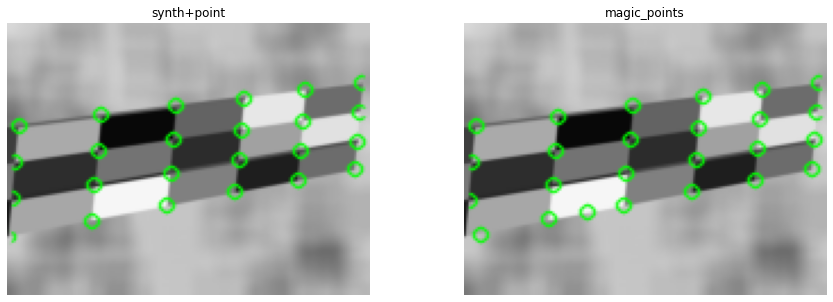

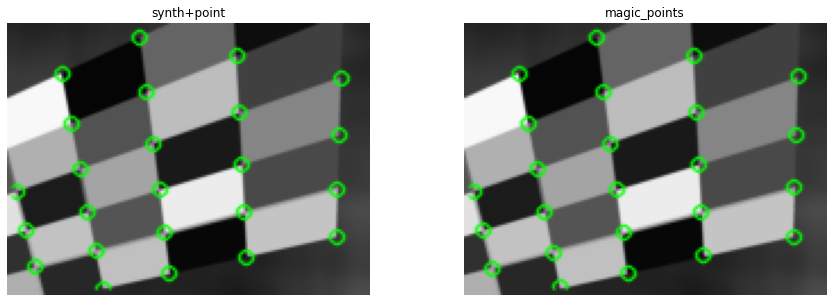

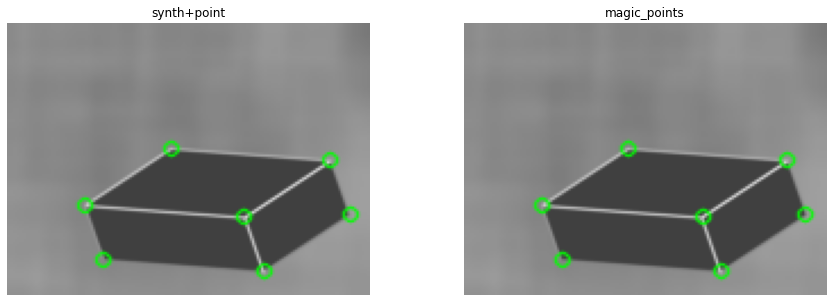

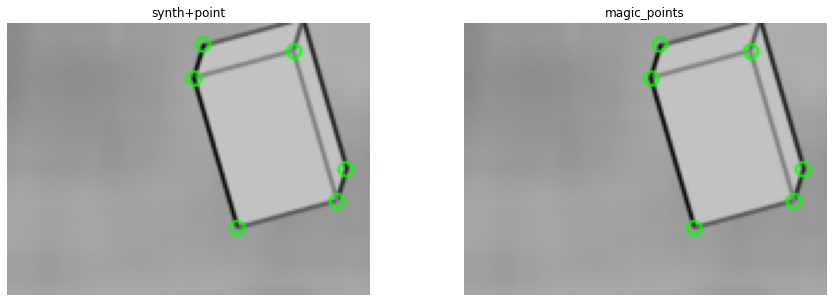

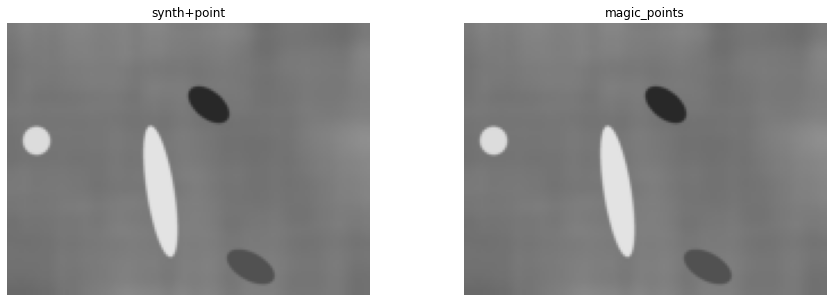

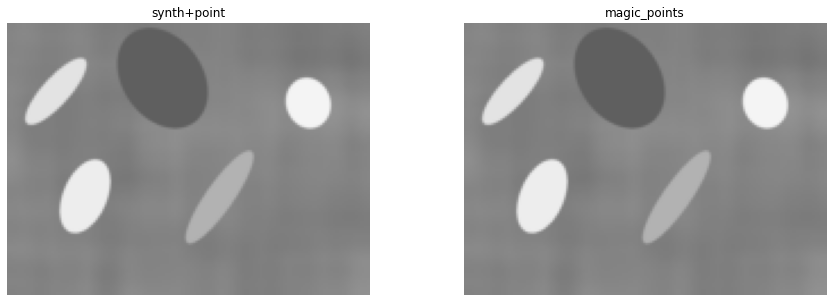

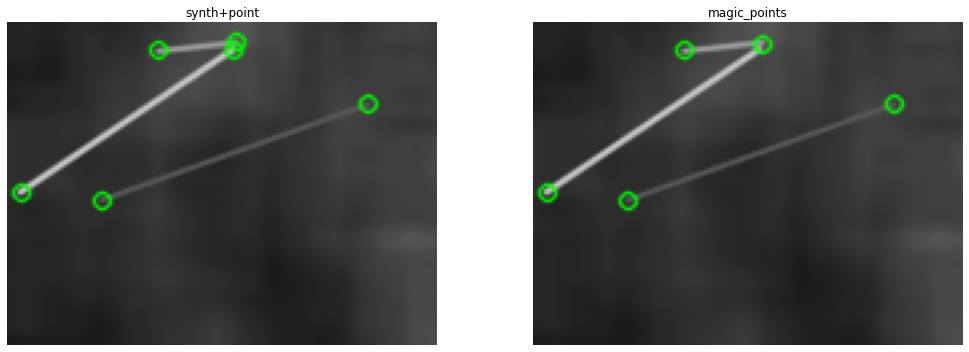

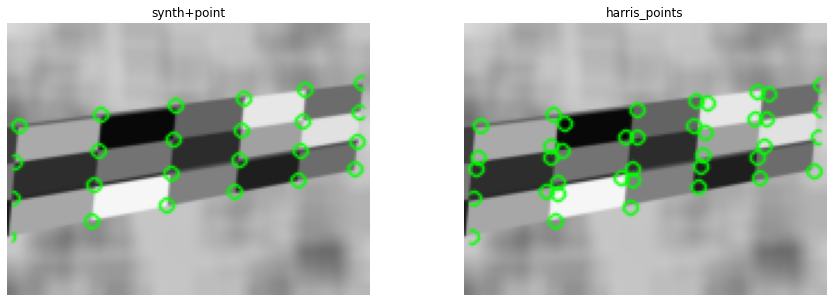

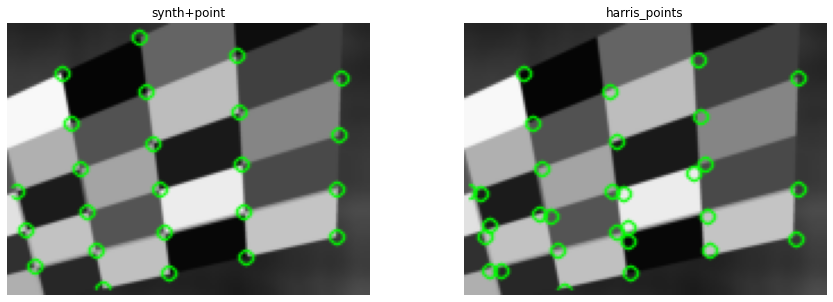

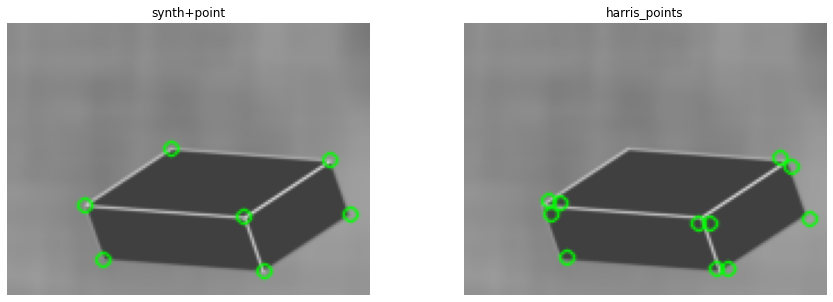

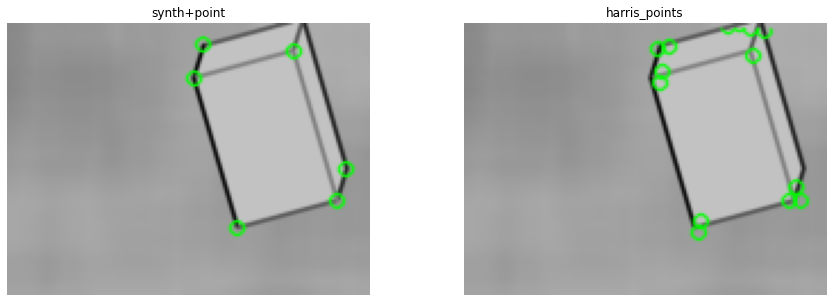

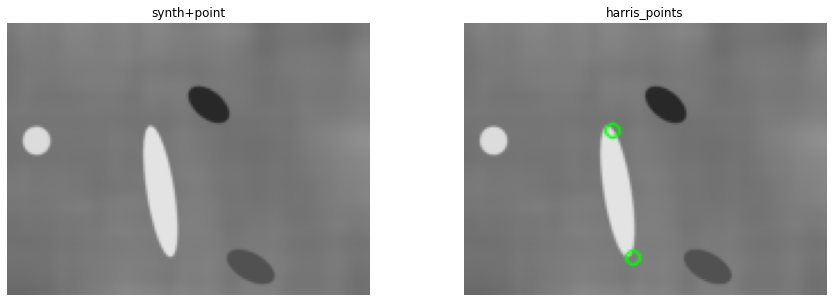

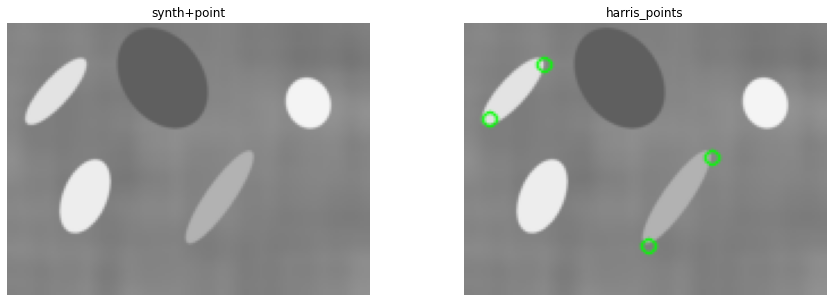

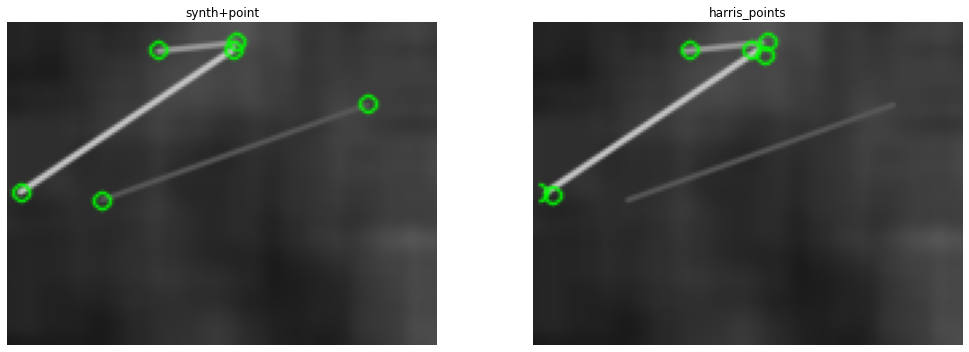

In [396]:
import tensorflow as tf


##Shapes generated by synthetic_shapes_generator
shape_dir_list = ['draw_checkerboard','draw_cube','draw_ellipses',
                  'draw_lines','draw_multiple_polygons','draw_star',
                  'draw_stripes']
num_images_per_shape = 2

## SYNTH IMAGE & POINT PATH
data_dir = "C:\\vrsk.psk.family\\Selva\\BitsPilani\\azure\\semester4\\semester4\\tmp\\"
img_dir = '\\images\\test\\'
p_dir = '\\points\\test\\'
synth_image_list, synth_point_list, synth_shapes_list = getRandomSynthList(shape_dir_list, data_dir, img_dir, p_dir,num_images_per_shape)

## MAGIC POINT IMAGE & POINT PATH
magic_point_data_dir = "C:\\vrsk.psk.family\\Selva\\BitsPilani\\azure\\semester4\\semester4\\experiment\\outputs\\magic-point_synth-export_all\\<synth_shape>\\points\\test\\"


################## DISPLAY SAMPLE IMAGES#############################
experiments = {
    'magic_points' : {'classic' : False, 'func_name' : magicpoint, 'threshold' : 0.001, 'display_func_name' : display_magic, 'point_dir' : magic_point_data_dir },
    'harris_points' : {'classic' : True, 'func_name' : harris_detector, 'threshold' : 90000, 'display_func_name' : display_harris, 'point_dir' : None }, 
#     'sift_points' : {'classic' : True,'func_name' : sift_detector, 'threshold' : 0.001, 'display_func_name' : display_sift, 'point_dir' : None }
}

for key in experiments.keys():
    print('====================== '+key.upper()+' =======================')
    func_name = experiments[key]['func_name']
    threshold = experiments[key]['threshold']
    display_func = experiments[key]['display_func_name']
    point_dir = experiments[key]['point_dir']
    classic_model = experiments[key]['classic']
    if classic_model:
        data = iterateClassicData(synth_image_list, synth_point_list , synth_shapes_list, func_name)
    else:
        data = iterateData(synth_image_list, synth_point_list , synth_shapes_list, point_dir, func_name)
    ## Plot synthetic images generated.
    Tot = len(shape_dir_list) * num_images_per_shape
    Cols = 2

    # Compute Rows required
    Rows = Tot // Cols  # it should be 14
    Rows += Tot % Cols # ZERO added

    # Create a Position index
    Position = range(1,Tot,Cols)
    print(Position, Rows)

    for k in Position:
        try:
            data_rec = next(data)
            source_img = display(data_rec.copy())
            magic_img = display_func(data_rec.copy())

            fig , a =  plt.subplots(1,Cols, figsize = (15,5))
            for ax, incr in zip(a,range(0,Cols)):
                if incr == 0:
                    ax.imshow(source_img)
                    ax.get_yaxis().set_ticks([])
                    ax.get_xaxis().set_ticks([])
                    ax.set_title(str('synth+point'))
                if incr == 1:
                    ax.imshow(magic_img)
                    ax.get_yaxis().set_ticks([])
                    ax.get_xaxis().set_ticks([])
                    ax.set_title(str(key))

                for spine in ax.spines.values():  # remove frame
                    spine.set_visible(False)

        except tf.errors.OutOfRangeError:
            break

    plt.tight_layout()  

# CALCULATE PRECISION & RECALL

In [404]:
def compute_precision_recall(synth_kp_map, synth_kp, model_kp, model_prob, dist_threshold):

    gt = np.where(synth_kp_map)
    gt = np.stack([gt[0], gt[1]], axis=-1)
    n_gt = len(gt)
    
    prob = model_prob
    pred = model_kp 
   
    # sort by probability
    sort_idx = np.argsort(prob)[::-1]
    prob = prob[sort_idx]
    pred = pred[sort_idx]
    
    diff = np.expand_dims(gt, axis=1) - np.expand_dims(pred, axis=0)
    dist = np.linalg.norm(diff, axis=-1)
    matches = np.less_equal(dist, dist_threshold)
    
    # Accumulate tp
    tp = []
    matched = np.zeros(len(gt))
    for m, m_idx in zip(matches, range(len(gt))):
        if np.any(m):
            gt_idx = np.argmax(m)
            if matched[m_idx] == 0 :
                matched[m_idx] = prob[gt_idx]
                tp.append(True)
#             matched[m_idx] = prob[gt_idx]
#             tp.append(True)
                
            else:
                tp.append(False)
        else:
            tp.append(False)
    
    tp = np.array(tp, bool)
    fp = np.logical_not(tp)

    return tp, fp, matched, n_gt

def experiment_level_pr( data, dist_threshold ):
    '''
        Loop through each image for calculating true positive/false positive
    '''
    tp, fp, prob, n_gt = [], [], [], 0
    while True:
        try:
            data_rec = next(data)
            synth_kp = data_rec['keypoints']
            synth_kp_map = data_rec['keypoints_map']
#             print(synth_kp.shape, synth_prob.shape)
            exp_kp = data_rec['model_keypoints']['points']
            exp_prob = data_rec['model_keypoints']['prob']
#             print('exp_kp.shape, exp_prob.shape: ',exp_kp.shape, exp_prob.shape)

            t, f, p, n = compute_precision_recall(synth_kp_map, synth_kp, exp_kp, exp_prob, dist_threshold)
#             print(t.shape, f.shape, p.shape, n)
            tp.append(t)
            fp.append(f)
            prob.append(p)
#             print(tp, fp, prob)
            n_gt += n

        except tf.errors.OutOfRangeError:
            break

    tp = np.concatenate(tp)
    fp = np.concatenate(fp)
    prob = np.concatenate(prob)

    # Sort in descending order of confidence
    sort_idx = np.argsort(prob)[::-1]
    tp = tp[sort_idx]
    fp = fp[sort_idx]
    prob = prob[sort_idx]

    tp_cum = np.cumsum(tp)
    fp_cum = np.cumsum(fp)
    recall = np.where(n_gt == 0, n_gt, tp_cum/n_gt)
    precision = np.where(tp_cum+fp_cum == 0, 0, tp_cum/(tp_cum+fp_cum))

    recall = np.concatenate([[0], recall, [1]])
    precision = np.concatenate([[0], precision, [0]])
    precision = np.maximum.accumulate(precision[::-1])[::-1]

    return precision, recall, prob

def compute_mAP(precision, recall):
    """
    Compute average precision.
    """
    return np.sum(precision[1:] * (recall[1:] - recall[:-1]))

====================== MAGIC_POINTS =======================
> magic_points
mAP: 0.9776299023078012
====================== HARRIS_POINTS =======================
> harris_points
mAP: 0.8152343196941809


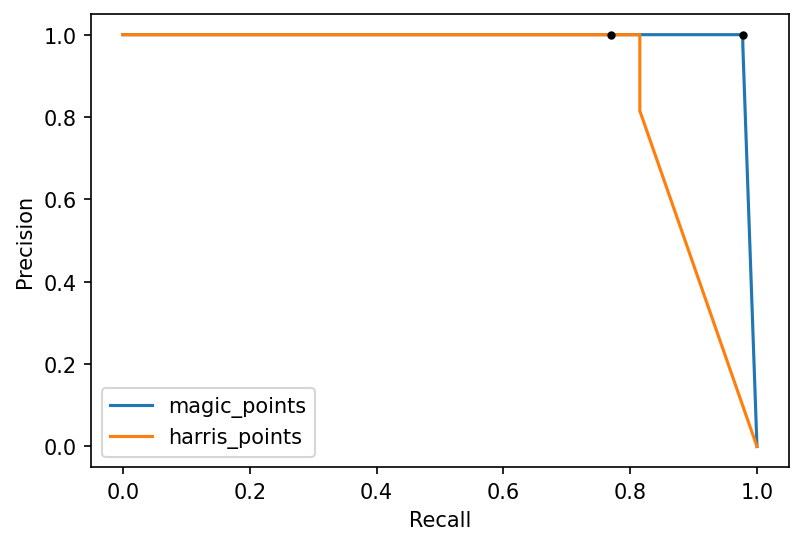

In [408]:
import tensorflow as tf


##Shapes generated by synthetic_shapes_generator
shape_dir_list = ['draw_checkerboard','draw_cube','draw_ellipses',
                  'draw_lines','draw_multiple_polygons','draw_star',
                  'draw_stripes']
num_images_per_shape = 100

## SYNTH IMAGE & POINT PATH
data_dir = "C:\\vrsk.psk.family\\Selva\\BitsPilani\\azure\\semester4\\semester4\\tmp\\"
img_dir = '\\images\\test\\'
p_dir = '\\points\\test\\'
synth_image_list, synth_point_list, synth_shapes_list = getRandomSynthList(shape_dir_list, data_dir, img_dir, p_dir,num_images_per_shape)

## MAGIC POINT IMAGE & POINT PATH
magic_point_data_dir = "C:\\vrsk.psk.family\\Selva\\BitsPilani\\azure\\semester4\\semester4\\experiment\\outputs\\magic-point_synth-export_all\\<synth_shape>\\points\\test\\"


################## DISPLAY SAMPLE IMAGES#############################
experiments = {
    'magic_points' : {'threshold': 0.001, 'classic' : False, 'func_name' : magicpoint, 'threshold' : 0.001, 'display_func_name' : display_magic, 'point_dir' : magic_point_data_dir },
    'harris_points' : {'threshold': 90000,'classic' : True, 'func_name' : harris_detector, 'threshold' : 90000, 'display_func_name' : display_harris, 'point_dir' : None }, 
#     'sift_points' : {'classic' : True,'func_name' : sift_detector, 'threshold' : 0.001, 'display_func_name' : display_sift, 'point_dir' : None }
}

plt.figure(dpi=150)

for key in experiments.keys():
    print('====================== '+key.upper()+' =======================')
    func_name = experiments[key]['func_name']
    threshold = experiments[key]['threshold']
    display_func = experiments[key]['display_func_name']
    point_dir = experiments[key]['point_dir']
    classic_model = experiments[key]['classic']
    threshold = experiments[key]['threshold']
     
    if classic_model:
        data = iterateClassicData(synth_image_list, synth_point_list , synth_shapes_list, func_name)
    else:
        data = iterateData(synth_image_list, synth_point_list , synth_shapes_list, point_dir, func_name)
    
    p, r, prob = experiment_level_pr(data, dist_threshold=4)
    plt.plot(r, p, label=key);

    mAP = compute_mAP(p, r)
    print('> {}'.format(key))
    print('mAP: {}'.format(mAP))

    op_idx = np.max(np.where(prob > threshold))
    plt.plot(r[op_idx], p[op_idx], marker='o', color='k', markersize=3)

plt.legend(), plt.xlabel('Recall'), plt.ylabel('Precision');